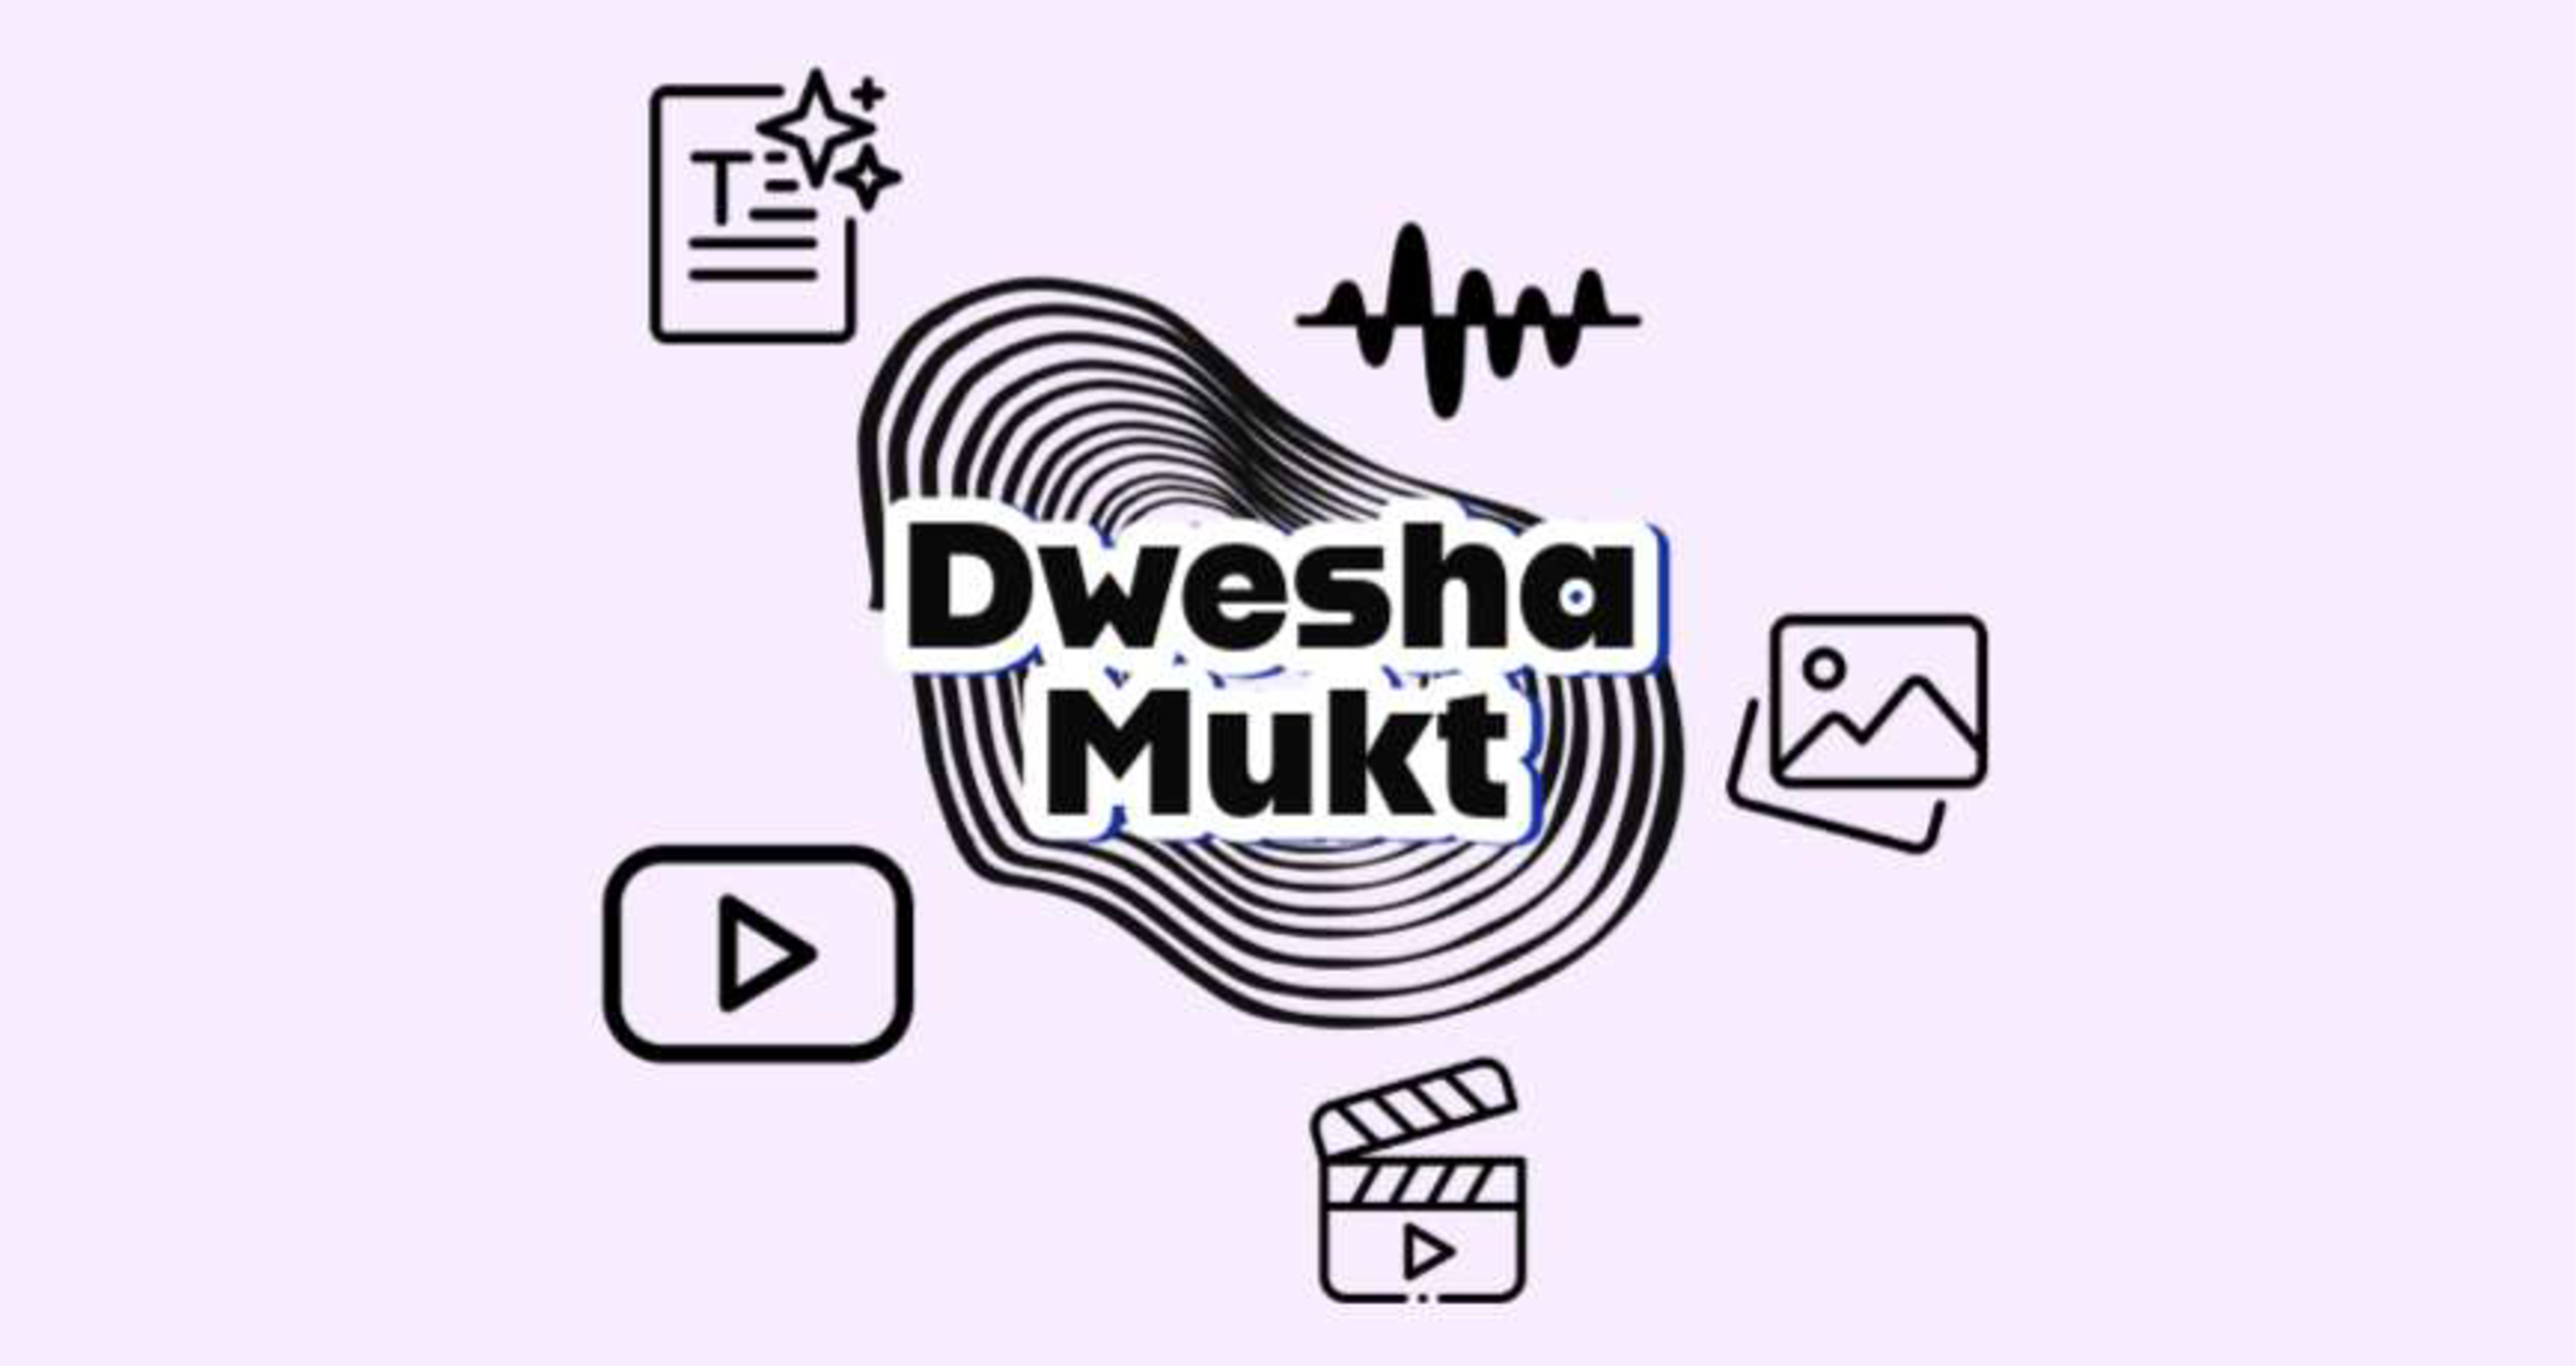

# **Installing and Importing Libraries**

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install tensorflow
!pip install transformers
!pip install google-cloud-speech
!apt install python3.10-venv
!python -m venv speech_to_text_demo
!source speech_to_text_demo/bin/activate
!pip install google-cloud-videointelligence
!pip install pytchat
!pip install google-cloud-vision
!pip install moviepy
!pip install --upgrade ffmpeg
!pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.4/289.4 kB 5.0 MB/s eta 0:00:00


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,473 kB of archives.
After this operation, 2,884 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.4 [1,680 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.1 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.4 [5,712 B]
Fetched 2,473 kB in 2s (1,097 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 123586 files and directories currently installed.)
Pr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.4/466.4 kB 7.9 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=9915ad011261400cab5166f8a2b9ee120c85ab4287ca97629d55c14a15621c8a
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import necessary libraries
import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import BertConfig
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from google.cloud import speech_v1
from IPython.display import display, Audio
from google.cloud import vision_v1
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.cloud.videointelligence_v1p3beta1.services.video_intelligence_service import VideoIntelligenceServiceClient
from google.cloud.videointelligence_v1p3beta1.types import Feature, VideoContext, TextDetectionConfig
from google.cloud.videointelligence_v1 import AnnotateVideoRequest, VideoContext, Feature, TextDetectionConfig
import moviepy.editor as mp
from google.colab import files
import pytchat
import time
import torch
import joblib

# **Importing Saved Model**

In [ ]:
def load_model_and_predict(text):
    # Load the BERT model and tokenizer
    model_directory = '/Hate Speech Hinglish Language/hate_speech_model'
    loaded_model = TFBertForSequenceClassification.from_pretrained(model_directory)
    loaded_tokenizer = BertTokenizer.from_pretrained(model_directory)

    # Load the TensorFlow model
    tf_model_filename = '/Hate Speech Hinglish Language/tf_model.h5'
    loaded_model.load_weights(tf_model_filename)

    # Load the label encoder
    label_encoder_filename = '/Hate Speech Hinglish Language/label_encoder.pkl'
    loaded_label_encoder = joblib.load(label_encoder_filename)

    # Tokenize and preprocess the input text
    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    return predicted_label

# **Defining User Scenarios**

In [5]:
hateful_emojis = hateful_emojis = [u'😠', u'😡', u'🤬', u'🥵', u'🤢', u'🤮', u'👿', u'💩', u'👎', u'👎🏻', u'👎🏼', u'👎🏽', u'👎🏾', u'👎🏿', u'🖕', u'🖕🏻', u'🖕🏼', u'🖕🏽', u'🖕🏾', u'🖕🏿', u'👙', u'🩱', u'💦', u'🍌', u'🍑', u'🥊', u'🏴‍☠️']

def has_hateful_emoji(text):
    for emoji in hateful_emojis:
        if emoji in text:
            return True
    return False

def predict_hate_speech(text, model, tokenizer, label_encoder, device):
    # Check for hateful emojis
    if has_hateful_emoji(text):
        return "yes"  # If hateful emoji is detected, classify as Hate

    encoding = loaded_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Make prediction
    with tf.device('/cpu:0'):  # Ensure predictions are made on CPU
        outputs = loaded_model.predict([input_ids, attention_mask])
        logits = outputs.logits

    # Convert logits to probabilities and get the predicted label
    probabilities = tf.nn.softmax(logits, axis=1).numpy()[0]
    predicted_label_id = np.argmax(probabilities)
    predicted_label = loaded_label_encoder.classes_[predicted_label_id]

    return predicted_label

# Function for Hate Speech Detection on Audio
def predict_hate_speech_audio(audio_content, model, tokenizer, label_encoder, device):
    # Convert audio to text using Google Speech-to-Text
    audio_text = convert_audio_to_text(audio_content)

    # Use the Hate Speech Detection model for prediction
    predicted_label = load_model_and_predict(audio_text)

    return predicted_label

# Function for Hate Speech Detection on Image (Scenario 3)
def predict_hate_speech_image(image_content, model, tokenizer, label_encoder, device):
    # Extract text from image using Google Cloud Vision API
    image_text = detect_text_from_image(image_content)

    # Use the Hate Speech Detection model for prediction
    predicted_label = load_model_and_predict(image_text)

    return predicted_label

# Function for Hate Speech Detection on Live YouTube Video (Scenario 5)
def predict_hate_speech_live_youtube(video_id, model, tokenizer, label_encoder, device):
    # Get live comments from a live YouTube video
    live_comments_df = get_live_comments(video_id)

    # Apply Hate Speech Detection on live comments
    classified_live_comments = []

    for live_comment_text in live_comments_df['message']:
        predicted_label = predict_hate_speech(live_comment_text, model, tokenizer, label_encoder, device)
        classified_live_comments.append((live_comment_text, predicted_label))

    return classified_live_comments

# Function to convert audio to text using Google Speech-to-Text
def convert_audio_to_text(audio_content):
    client = speech_v1.SpeechClient()

    # Configure audio recognition settings
    config = speech_v1.RecognitionConfig(
        encoding=speech_v1.RecognitionConfig.AudioEncoding.MP3,
        sample_rate_hertz=44100,
        language_code="en-US",
        model="video",
    )

    audio = speech_v1.RecognitionAudio(content=audio_content)

    # Recognize speech
    response = client.recognize(config=config, audio=audio)

    # Extract the transcriptions
    transcriptions = [result.alternatives[0].transcript for result in response.results]

    # Concatenate transcriptions into a single text
    text = ' '.join(transcriptions)

    return text

# Set Google Cloud Speech-to-Text API credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Speech Recognition/credentials1.json"

# Function to detect text from an image using Google Cloud Vision API (Scenario 3)
def detect_text_from_image(image_content):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Optical Character Recognition/credentials2.json"

    vision_client = vision_v1.ImageAnnotatorClient()

    image = vision_v1.Image(content=image_content)

    response = vision_client.text_detection(image=image)

    texts = response.text_annotations
    detected_text = ""
    for text in texts:
        detected_text += text.description + " "

    return detected_text.strip()


# Function for Live YouTube Video Comments
def get_live_comments_with_timeout(video_id, timeout_seconds=3):
    chat = pytchat.create(video_id=video_id)

    live_comments = []
    start_time = time.time()

    while chat.is_alive():
        for c in chat.get().sync_items():
            live_comments.append([c.datetime, c.author.name, c.message])

        # Check timeout
        elapsed_time = time.time() - start_time
        if elapsed_time >= timeout_seconds:
            break

    return pd.DataFrame(live_comments, columns=['datetime', 'author', 'message'])

def classify_live_comments(comments_df, model, tokenizer, label_encoder, device):
    classified_live_comments = []

    for live_comment_text in comments_df['message']:
        predicted_label = load_model_and_predict(live_comment_text)
        classified_live_comments.append((live_comment_text, predicted_label))

    return pd.DataFrame(classified_live_comments, columns=['live_comment_text', 'hate_speech_label'])

# Device specification (remove any explicit device specification)
torch_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# **User Interface**

In [ ]:
print("1 = Text Classification")
print("2 = Audio Classification")
print("3 = Image Classification")
print("4 = GIF Classification")
print("5 = Video Classification")
print("6 = Youtube Live Classification")

while True:
    # Take user input for scenario choice
    user_choice = input("Enter the scenario choice (1-6), or 'Cancel' to exit: ")

    if user_choice.lower() == 'cancel':
        print("Exiting the program.")
        break

    elif user_choice == '1':
        print("Text Classification")
        user_text = input("Enter a text to classify: ")
        predicted_label = load_model_and_predict(user_text)
        print("Text Classification")
        print(f'Text: "{user_text}"')
        print(f'Predicted Label: {predicted_label}')
        print()
        print()

    elif user_choice == '2':
        print("Audio Classification")
        # Upload audio file
        uploaded = files.upload()
        audio_filename = list(uploaded.keys())[0]
        audio_content = uploaded[audio_filename]
        audio_text = convert_audio_to_text(audio_content)
        predicted_label_audio = load_model_and_predict(audio_text)
        print("Audio Classification")
        print(f'Text Extracted from Audio: "{audio_text}"')
        print(f'Hate Speech Prediction for Audio: {predicted_label_audio}')
        print()
        print()

    elif user_choice == '3':
        print("Image Classification")
        # Upload image file
        uploaded_files = files.upload()
        image_content = list(uploaded_files.values())[0]
        image_text = detect_text_from_image(image_content)
        predicted_label_image = load_model_and_predict(user_text)
        print("Image Classification")
        print(f'Text Extracted from Image: "{image_text}"')
        print(f'Hate Speech Prediction for Image: {predicted_label_image}')
        print()

    elif user_choice == '4':
        print("GIF Classification")
        # Scenario 4: Video file entered by the user
        # Set up authentication for Video Intelligence API
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Optical Character Recognition/credentials3.json"

        # Allow the user to upload a video
        from google.colab import files
        video_upload = files.upload()

        # Ensure there is exactly one video file
        assert len(video_upload) == 1, "Please upload one video file at a time."

        video_file_name = next(iter(video_upload))  # Get filename directly
        video_content = video_upload[video_file_name]

        # Perform text detection on the uploaded video
        client = videointelligence.VideoIntelligenceServiceClient()

        # Configure the request
        features = [Feature.TEXT_DETECTION]
        config = videointelligence.TextDetectionConfig(language_hints=["en"])
        context = videointelligence.VideoContext(text_detection_config=config)

        request = videointelligence.AnnotateVideoRequest(
            input_content=video_content,
            features=features,
            video_context=context
        )

        # Execute the request
        operation = client.annotate_video(request)
        print("Started text detection operation. Waiting for results...")
        results = operation.result(timeout=300)

        # Get and print results
        annotation_results = results.annotation_results[0]
        gif_text = ""
        for text_annotation in annotation_results.text_annotations:
            gif_text += text_annotation.text + " "

        # Apply Hate Speech Detection on Extracted Text
        predicted_label = load_model_and_predict(gif_text)

        # Print or use the result
        print("GIF Classification")
        print(f'Text Extracted from GIF: "{gif_text}"')
        print(f'Hate Speech Detection Result: {predicted_label}')
        print()
        print()

    elif user_choice == '5':
        print("Video Classification")
        # Allow the user to upload a video with background audio
        video_upload = files.upload()

        # Ensure there is exactly one video file
        assert len(video_upload) == 1, "Please upload one video file at a time."

        # Extract the file content from the dictionary
        video_file_name = list(video_upload.keys())[0]
        video_content = video_upload[video_file_name]

        # Save the video content to a temporary file
        with open(video_file_name, 'wb') as video_file:
            video_file.write(video_content)

        print()
        print("Task 1 : Audio inside Video is processed")
        # Use the temporary file to create VideoFileClip
        clip = mp.VideoFileClip(video_file_name)

        # Save the audio file to the specified location
        audio_output_path = r"/Video to Audio/video_to_audio.mp3"
        clip.audio.write_audiofile(audio_output_path)

        # Upload audio file
        uploaded = audio_output_path
        audio_content = open(uploaded, 'rb').read()
        audio_text = convert_audio_to_text(audio_content)
        predicted_label_audio = load_model_and_predict(audio_text)
        print("Video Classification")
        print(f'Text Extracted from Audio inside Video : "{audio_text}"')
        print(f'Hate Speech Prediction for Audio inside Video : {predicted_label_audio}')
        print()

        print("Task 2 : Text inside Video is processed")
        os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"/Optical Character Recognition/credentials3.json"

        video_file_name = list(video_upload.keys())[0]
        video_content = video_upload[video_file_name]

        # Perform text detection on the uploaded video
        client = videointelligence.VideoIntelligenceServiceClient()

        # Configure the request
        features = [Feature.TEXT_DETECTION]
        config = videointelligence.TextDetectionConfig(language_hints=["en"])
        context = videointelligence.VideoContext(text_detection_config=config)

        request = videointelligence.AnnotateVideoRequest(
            input_content=video_content,
            features=features,
            video_context=context
        )

        # Execute the request
        operation = client.annotate_video(request)
        print("Started text detection operation. Waiting for results...")
        results = operation.result(timeout=300)

        # Get and print results
        annotation_results = results.annotation_results[0]
        video_text = ""
        for text_annotation in annotation_results.text_annotations:
            video_text += text_annotation.text + " "

        # Apply Hate Speech Detection on Extracted Text
        predicted_label = load_model_and_predict(video_text)

        # Print or use the result
        print("Video Classification")
        print(f'Text Extracted from Video : "{video_text}"')
        print(f'Hate Speech Detection Result : {predicted_label}')
        print()
        print()

    elif user_choice == "6":
        print("Youtube Live Comments Classification")
        # Scenario 6: Live YouTube Video
        live_video_id = input("Enter the YouTube live stream video ID: ")
        live_comments_df = get_live_comments_with_timeout(live_video_id, timeout_seconds=3)
        classified_live_comments = classify_live_comments(live_comments_df, loaded_model, loaded_tokenizer, loaded_label_encoder, torch_device)
        print("Youtube Live Comments Classification")
        print(classified_live_comments)
        print()

    else:
        print("Invalid choice. Please enter a valid scenario choice (1-6) or 'Cancel'.")